In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import shutil

In [3]:
def data_augmentation(input_dir, output_dir):
    # List all classes (assuming each subdirectory represents a class)
    classes = os.listdir(input_dir)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Clear existing files in the directory
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    # Dictionary to store file paths for each class
    data = {cls: [] for cls in classes}

    # Gather file paths for each class
    for cls in classes:
        cls_dir = os.path.join(input_dir, cls)
        data[cls] = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]

    # ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate and save augmented images
    for cls, files in data.items():
        cls_augmented_dir = os.path.join(output_dir, cls)
        os.makedirs(cls_augmented_dir)

        for file in files:
            img = load_img(file)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=cls_augmented_dir, save_prefix=cls, save_format='jpg'):
                i += 1
                if i >= 5:  # Generate 5 augmented images for each original image
                    break

In [4]:
# Usage example:
input_directory = "D:/Drone/New folder (2)/asl_alphabet_train"
output_directory = "D:/Drone/New folder (2)/asl_alphabet_train_augmented"

data_augmentation(input_directory, output_directory)

# Load and preprocess the dataset

In [2]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Define the path to the dataset
data_dir = "D:/Drone/New folder (2)/asl_alphabet_train"

# List all classes (assuming each subdirectory represents a class)
classes = os.listdir(data_dir)

# Dictionary to store file paths for each class
data = {cls: [] for cls in classes}

In [3]:
# Gather file paths for each class
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    data[cls] = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]

# Split data into train, test, and validation sets

In [4]:
# Split data into train, test, and validation sets
train_data = {}
test_data = {}
val_data = {}
for cls, files in data.items():
    train, test = train_test_split(files, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 (20% validation)
    train_data[cls] = train
    test_data[cls] = test
    val_data[cls] = val

In [5]:
# Create DataFrames for train, test, and validation sets
train_df = pd.DataFrame([(file, cls) for cls, files in train_data.items() for file in files], columns=['file', 'class'])
test_df = pd.DataFrame([(file, cls) for cls, files in test_data.items() for file in files], columns=['file', 'class'])
val_df = pd.DataFrame([(file, cls) for cls, files in val_data.items() for file in files], columns=['file', 'class'])

# ImageDataGenerator

In [6]:
# ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [7]:
# Flow from dataframe for train, test, and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10800 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


# Build The CNN Model

In [17]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))  # 6 classes for the gestures

In [18]:
from keras.optimizers import Adam
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # adjust as needed
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
338/338 [==============================] - 411s 1s/step - loss: 1.6533 - accuracy: 0.2911 - val_loss: 1.1503 - val_accuracy: 0.5708
Epoch 2/10
338/338 [==============================] - 348s 1s/step - loss: 0.8739 - accuracy: 0.6643 - val_loss: 0.6345 - val_accuracy: 0.7633
Epoch 3/10
338/338 [==============================] - 345s 1s/step - loss: 0.5850 - accuracy: 0.7809 - val_loss: 0.3924 - val_accuracy: 0.8569
Epoch 4/10
338/338 [==============================] - 344s 1s/step - loss: 0.4374 - accuracy: 0.8451 - val_loss: 0.2686 - val_accuracy: 0.9094
Epoch 5/10
338/338 [==============================] - 345s 1s/step - loss: 0.3331 - accuracy: 0.8878 - val_loss: 0.2155 - val_accuracy: 0.9233
Epoch 6/10
338/338 [==============================] - 344s 1s/step - loss: 0.2604 - accuracy: 0.9131 - val_loss: 0.3054 - val_accuracy: 0.8972
Epoch 7/10
338/338 [==============================] - 345s 1s/step - loss: 0.1980 - accuracy: 0.9344 - val_loss: 0.1557 - val_accuracy: 0.9500

# Loss

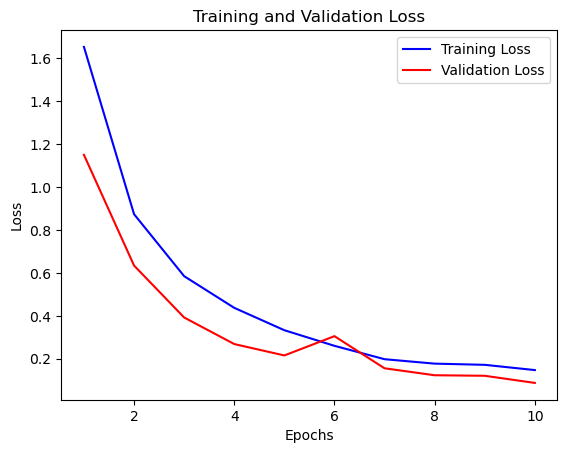

In [20]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [21]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

113/113 [==============================] - 54s 478ms/step - loss: 0.0664 - accuracy: 0.9761
Accuracy on test data: 97.61%


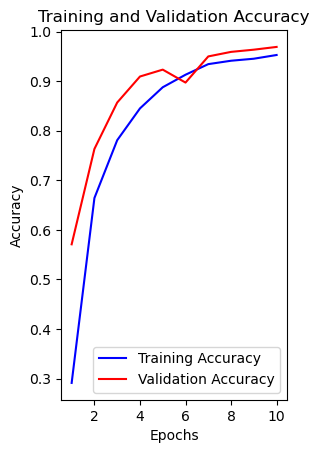

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Other Measurments

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

113/113 [==============================] - 44s 387ms/step


# Confusion Matrix

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 96  89 108 109  95 103]
 [102  90 106 101  97 104]
 [112 108  94  83 106  97]
 [ 95  92 113 106 103  91]
 [103  95 109 115  84  94]
 [109  97  89  72 118 115]]


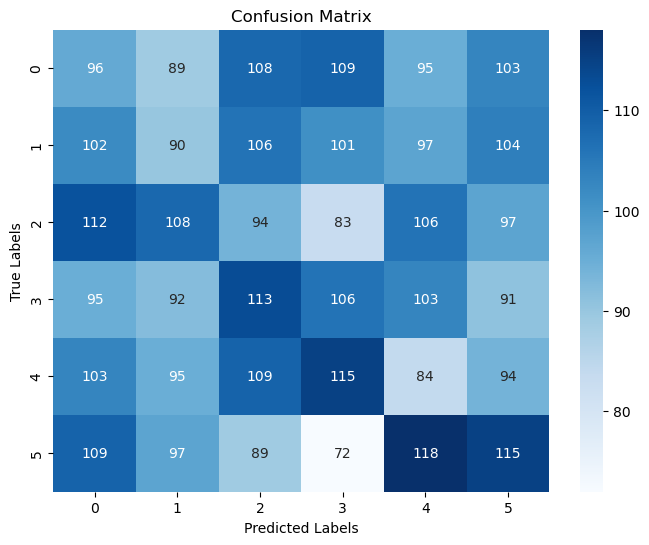

In [25]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report

In [26]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.16      0.16       600
           1       0.16      0.15      0.15       600
           2       0.15      0.16      0.15       600
           3       0.18      0.18      0.18       600
           4       0.14      0.14      0.14       600
           5       0.19      0.19      0.19       600

    accuracy                           0.16      3600
   macro avg       0.16      0.16      0.16      3600
weighted avg       0.16      0.16      0.16      3600



# Save The Model

In [27]:
# Assuming you've trained and have a model object named 'model'
model.save('CNN_model02.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Rewrite the model as it overfit

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN model with dropout and regularization
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

# Using callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [10]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
338/338 [==============================] - 437s 1s/step - loss: 1.7898 - accuracy: 0.1930 - val_loss: 1.7203 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 2/10
338/338 [==============================] - 378s 1s/step - loss: 1.5318 - accuracy: 0.3683 - val_loss: 1.1765 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 3/10
338/338 [==============================] - 377s 1s/step - loss: 0.8169 - accuracy: 0.7035 - val_loss: 0.5742 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 4/10
338/338 [==============================] - 370s 1s/step - loss: 0.5821 - accuracy: 0.7965 - val_loss: 0.4415 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 5/10
338/338 [==============================] - 373s 1s/step - loss: 0.4293 - accuracy: 0.8583 - val_loss: 0.3707 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 6/10
338/338 [==============================] - 374s 1s/step - loss: 0.3445 - accuracy: 0.8815 - val_loss: 0.3026 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 7/10
338/338 [==============================] - 371s 1s/st

# Loss

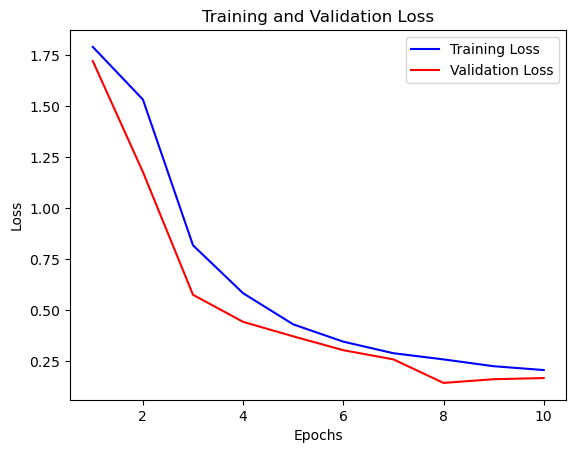

In [18]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [19]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

113/113 [==============================] - 34s 297ms/step - loss: 0.1613 - accuracy: 0.9456
Accuracy on test data: 94.56%


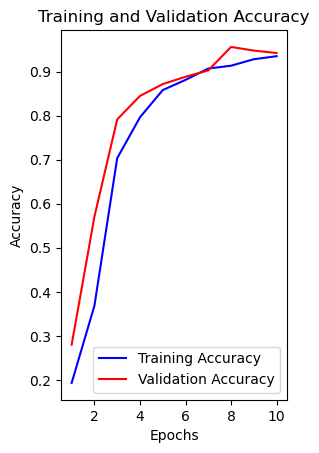

In [20]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

113/113 [==============================] - 34s 299ms/step


# Confusion Matrix

In [22]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 96  86  99 105  91 123]
 [105  91 106  83  84 131]
 [116 102  94  85 105  98]
 [103  98  94 101 104 100]
 [104  95 108  97 100  96]
 [102  85 104 121  75 113]]


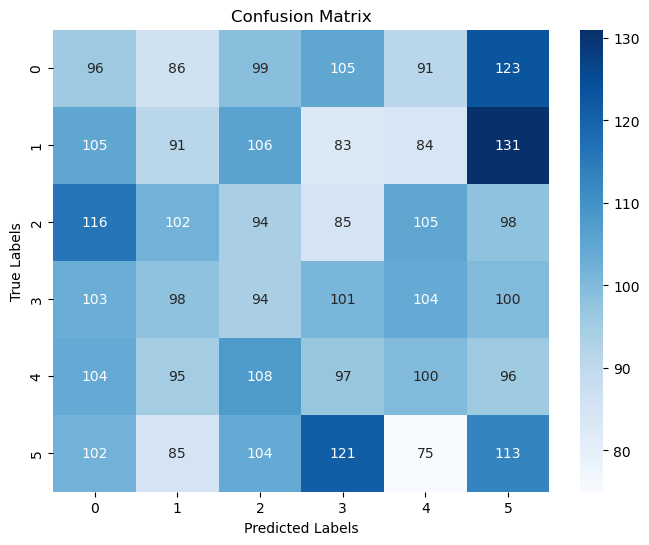

In [23]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report

In [24]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.16      0.16       600
           1       0.16      0.15      0.16       600
           2       0.16      0.16      0.16       600
           3       0.17      0.17      0.17       600
           4       0.18      0.17      0.17       600
           5       0.17      0.19      0.18       600

    accuracy                           0.17      3600
   macro avg       0.17      0.17      0.17      3600
weighted avg       0.17      0.17      0.17      3600



# Save The Model

In [25]:
model.save('CNN_model03.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Use ResNet 

In [8]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Create the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the ResNet50 base model
model = Sequential()
model.add(base_model)

# Add additional layers on top of the ResNet50 base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # adjust as needed
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
338/338 [==============================] - 564s 2s/step - loss: 1.7889 - accuracy: 0.2075 - val_loss: 1.7247 - val_accuracy: 0.2383
Epoch 2/10
338/338 [==============================] - 520s 2s/step - loss: 1.7044 - accuracy: 0.2584 - val_loss: 1.6550 - val_accuracy: 0.3317
Epoch 3/10
338/338 [==============================] - 521s 2s/step - loss: 1.6671 - accuracy: 0.2897 - val_loss: 1.6209 - val_accuracy: 0.3611
Epoch 4/10
338/338 [==============================] - 511s 2s/step - loss: 1.6597 - accuracy: 0.2828 - val_loss: 1.6136 - val_accuracy: 0.3461
Epoch 5/10
338/338 [==============================] - 509s 2s/step - loss: 1.6370 - accuracy: 0.2919 - val_loss: 1.6182 - val_accuracy: 0.3228
Epoch 6/10
338/338 [==============================] - 514s 2s/step - loss: 1.6213 - accuracy: 0.3099 - val_loss: 1.5773 - val_accuracy: 0.3444
Epoch 7/10
338/338 [==============================] - 511s 2s/step - loss: 1.6046 - accuracy: 0.3234 - val_loss: 1.5577 - val_accuracy: 0.3672

# Loss

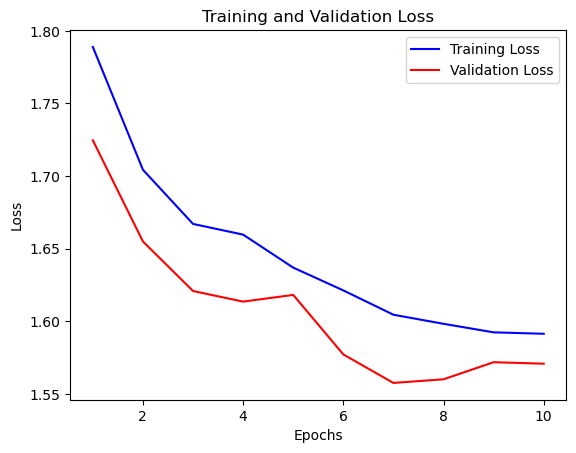

In [10]:
import matplotlib.pyplot as plt

# Accessing training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

In [11]:
# Evaluate the model on test data
accuracy = model.evaluate(test_generator, steps=len(test_generator))[1]
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

113/113 [==============================] - 130s 1s/step - loss: 1.5470 - accuracy: 0.3644
Accuracy on test data: 36.44%


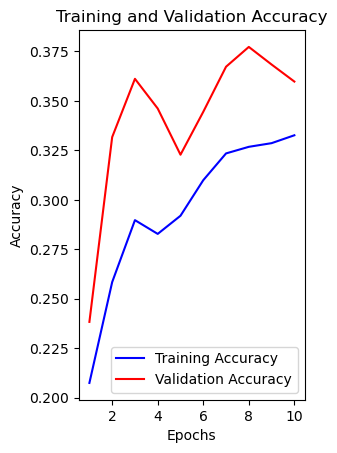

In [12]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting the loss graph
epochs = range(1, len(training_loss) + 1)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np

# Predict probabilities for test set
y_pred_prob = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes

113/113 [==============================] - 121s 1s/step


# Confusion Matrix

In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 31  26 122  51  47 323]
 [ 25  18 126  78  42 311]
 [ 31  16 126  76  51 300]
 [ 31  21 130  74  49 295]
 [ 34  10 120  68  48 320]
 [ 22  20 120  82  51 305]]


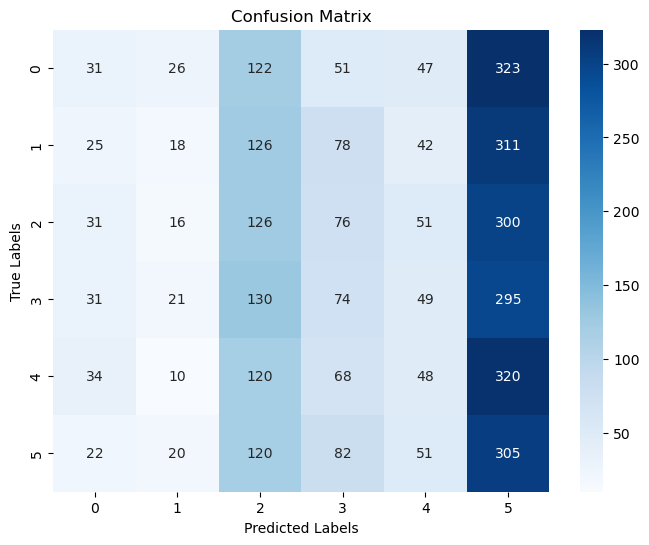

In [16]:
import numpy as np
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report

In [17]:
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.05      0.08       600
           1       0.16      0.03      0.05       600
           2       0.17      0.21      0.19       600
           3       0.17      0.12      0.14       600
           4       0.17      0.08      0.11       600
           5       0.16      0.51      0.25       600

    accuracy                           0.17      3600
   macro avg       0.17      0.17      0.14      3600
weighted avg       0.17      0.17      0.14      3600



# Save the Model 

In [18]:
model.save('CNN_model04.h5')

C:\Users\ADMIN\Conda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
